In [35]:
import requests
import json
import pandas as pd
from pandas import json_normalize
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import ast
import folium
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [3]:
url = 'http://localhost:9090/chronicepa79'
response = requests.get(url)
data = response.json()

df = json_normalize(data)
df.head(5)

,Local Government Area Code,Local Government Area Name,Chronic Obstructive Pulmonary Disease RRMSE,Persons with Mental and Behavioural Problems Rate per 100,Asthma RRMSE,Males with Mental and Behavioural Problems Rate per 100,Chronic Obstructive Pulmonary Disease Count,Hypertension Count,Hypertension RRMSE,Respiratory System Diseases Count,...,Males with Mental and Behavioural Problems RRMSE,Chronic Obstructive Pulmonary Disease Rate per 100,High Cholesterol RRMSE,Site Name,Parameters,Time,Local Government Area Shape.type,Local Government Area Shape.coordinates,relation_type.name,relation_type.parent
0,24900,moira,3,14.124853,3,11.989043,746.928469,3532.220757,3,8520.394817,...,3,2.218092,3,Yarrawonga,"[{'name': 'Particles', 'timeSeriesReadings': [...",2024-05-16T11:00:00Z,Polygon,"[[[146.21053866500006, -36.11527584499994], [1...",epa,7
1,26260,southern grampians,1,13.209631,3,11.293796,384.044127,1960.486051,3,5110.028063,...,3,2.020863,3,Hamilton,"[{'name': 'Particles', 'timeSeriesReadings': [...",2024-05-16T11:00:00Z,Polygon,"[[[142.36825914100007, -37.537848841999974], [...",epa,13
2,26260,southern grampians,1,13.209631,3,11.293796,384.044127,1960.486051,3,5110.028063,...,3,2.020863,3,Hamilton,"[{'name': 'Particles', 'timeSeriesReadings': [...",2024-05-16T11:00:00Z,Polygon,"[[[142.36825914100007, -37.537848841999974], [...",epa,13
3,23190,horsham,3,12.721789,3,11.570864,455.077486,2206.457495,3,6010.251990,...,3,2.148330,3,Horsham,"[{'name': 'Particles', 'timeSeriesReadings': [...",2024-05-16T11:00:00Z,Polygon,"[[[141.90024892200006, -37.134857923], [141.89...",epa,26
4,20570,ballarat,3,14.741662,3,12.516261,2101.595620,9510.684386,3,33557.834578,...,3,2.191521,3,Ballarat,"[{'name': 'Particles', 'timeSeriesReadings': [...",2024-05-16T11:00:00Z,Polygon,"[[[143.84322375600004, -37.67026968299998], [1...",epa,41


In [25]:
def parse_parameters(params):
    if isinstance(params, list) and len(params) > 0:
        return [(p['name'], p['timeSeriesReadings']) for p in params]
    return []

df['parsed_parameters'] = df['Parameters'].apply(parse_parameters)
df.head(1)

,Local Government Area Code,Local Government Area Name,Chronic Obstructive Pulmonary Disease RRMSE,Persons with Mental and Behavioural Problems Rate per 100,Asthma RRMSE,Males with Mental and Behavioural Problems Rate per 100,Chronic Obstructive Pulmonary Disease Count,Hypertension Count,Hypertension RRMSE,Respiratory System Diseases Count,...,Time,Local Government Area Shape.type,Local Government Area Shape.coordinates,relation_type.name,relation_type.parent,parsed_parameters,Particles,PM2_5,PM10,Center Coordinates
0,24900,moira,3,14.124853,3,11.989043,746.928469,3532.220757,3,8520.394817,...,2024-05-16T11:00:00Z,Polygon,"[[[146.21053866500006, -36.11527584499994], [1...",epa,7,"[(Particles, [{'timeSeriesName': '1HR_AV', 're...",11.58,NaN,NaN,"[145.46943744980516, -35.930065048941756]"


In [26]:
def expand_parameters(row):
    records = []
    for param, readings_list in row['parsed_parameters']:
        for reading in readings_list:
            time_series_name = reading['timeSeriesName']
            for reading_detail in reading['readings']:
                record = {
                    'Local Government Area Code': row['Local Government Area Code'],
                    'Local Government Area Name': row['Local Government Area Name'],
                    'Site Name': row['Site Name'],
                    'Time': row['Time'],
                    'Parameter Name': param,
                    'TimeSeries Name': time_series_name,
                    'Since': reading_detail.get('since', 'Unknown Time'),
                    'Until': reading_detail.get('until', 'Unknown Time'),
                    'Average Value': reading_detail.get('averageValue', 0),  # 默认值为0
                    'Unit': reading_detail.get('unit', 'Unknown Unit'),
                    'Confidence': reading_detail.get('confidence', 'Unknown Confidence'),
                    'Total Sample': reading_detail.get('totalSample', 'Unknown Sample'),
                    'Health Advice': reading_detail.get('healthAdvice', 'No Advice'),
                    'Health Advice Color': reading_detail.get('healthAdviceColor', 'No Color'),
                    'Health Code': reading_detail.get('healthCode', 'No Code')
                }
                records.append(record)
    return pd.DataFrame(records)


In [27]:
expanded_dataframes = df.apply(expand_parameters, axis=1)
expanded_df = pd.concat(expanded_dataframes.tolist(), ignore_index=True)
expanded_df.head(2)

,Local Government Area Code,Local Government Area Name,Site Name,Time,Parameter Name,TimeSeries Name,Since,Until,Average Value,Unit,Confidence,Total Sample,Health Advice,Health Advice Color,Health Code
0,24900,moira,Yarrawonga,2024-05-16T11:00:00Z,Particles,1HR_AV,2024-05-16T11:00:00Z,2024-05-16T12:00:00Z,14.05,&micro;g/m&sup3;,100,12,Good,#42A93C,9999
1,24900,moira,Yarrawonga,2024-05-16T11:00:00Z,Particles,24HR_AV,2024-05-15T12:00:00Z,2024-05-16T12:00:00Z,9.11,&micro;g/m&sup3;,100,288,Fair,#EEC900,9999


In [30]:
expanded_df['Particles'] = pd.to_numeric(expanded_df['Average Value'].where(expanded_df['Parameter Name'] == 'Particles'), errors='coerce')
expanded_df['PM2_5'] = pd.to_numeric(expanded_df['Average Value'].where(expanded_df['Parameter Name'] == 'PM2.5'), errors='coerce')
expanded_df['PM10'] = pd.to_numeric(expanded_df['Average Value'].where(expanded_df['Parameter Name'] == 'PM10'), errors='coerce')

air_quality_summary = expanded_df.groupby(['Local Government Area Name', 'Time']).agg({'Particles': 'mean', 'PM2_5': 'mean', 'PM10': 'mean'}).reset_index()

df = pd.merge(df, air_quality_summary, on=['Local Government Area Name', 'Time'], how='left')
df.head(2)

,Local Government Area Code,Local Government Area Name,Chronic Obstructive Pulmonary Disease RRMSE,Persons with Mental and Behavioural Problems Rate per 100,Asthma RRMSE,Males with Mental and Behavioural Problems Rate per 100,Chronic Obstructive Pulmonary Disease Count,Hypertension Count,Hypertension RRMSE,Respiratory System Diseases Count,...,Particles_x,PM2_5_x,PM10_x,Center Coordinates,Particles_y,PM2_5_y,PM10_y,Particles,PM2_5,PM10
0,24900,moira,3,14.124853,3,11.989043,746.928469,3532.220757,3,8520.394817,...,11.58,NaN,NaN,"[145.46943744980516, -35.930065048941756]",11.58,NaN,NaN,11.58,NaN,NaN
1,26260,southern grampians,1,13.209631,3,11.293796,384.044127,1960.486051,3,5110.028063,...,13.81,NaN,NaN,"[141.83617863769456, -37.34641439480638]",13.81,NaN,NaN,13.81,NaN,NaN


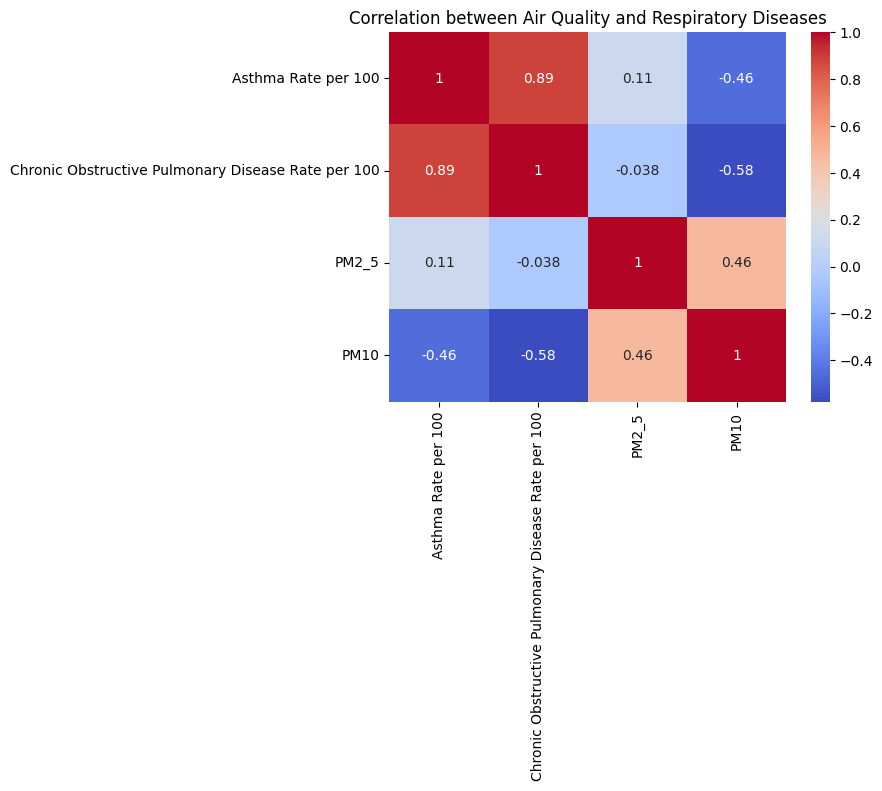

In [42]:
correlation_matrix = df[['Asthma Rate per 100', 'Chronic Obstructive Pulmonary Disease Rate per 100', 'PM2_5', 'PM10']].corr()

sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation between Air Quality and Respiratory Diseases')
plt.show()

Available columns for correlation: ['Persons with Mental and Behavioural Problems Rate per 100', 'Males with Mental and Behavioural Problems Rate per 100', 'Chronic Obstructive Pulmonary Disease Count', 'Hypertension Count', 'Respiratory System Diseases Count', 'Chronic Obstructive Pulmonary Disease Rate per 100', 'Asthma Rate per 100', 'Particles', 'PM2_5']


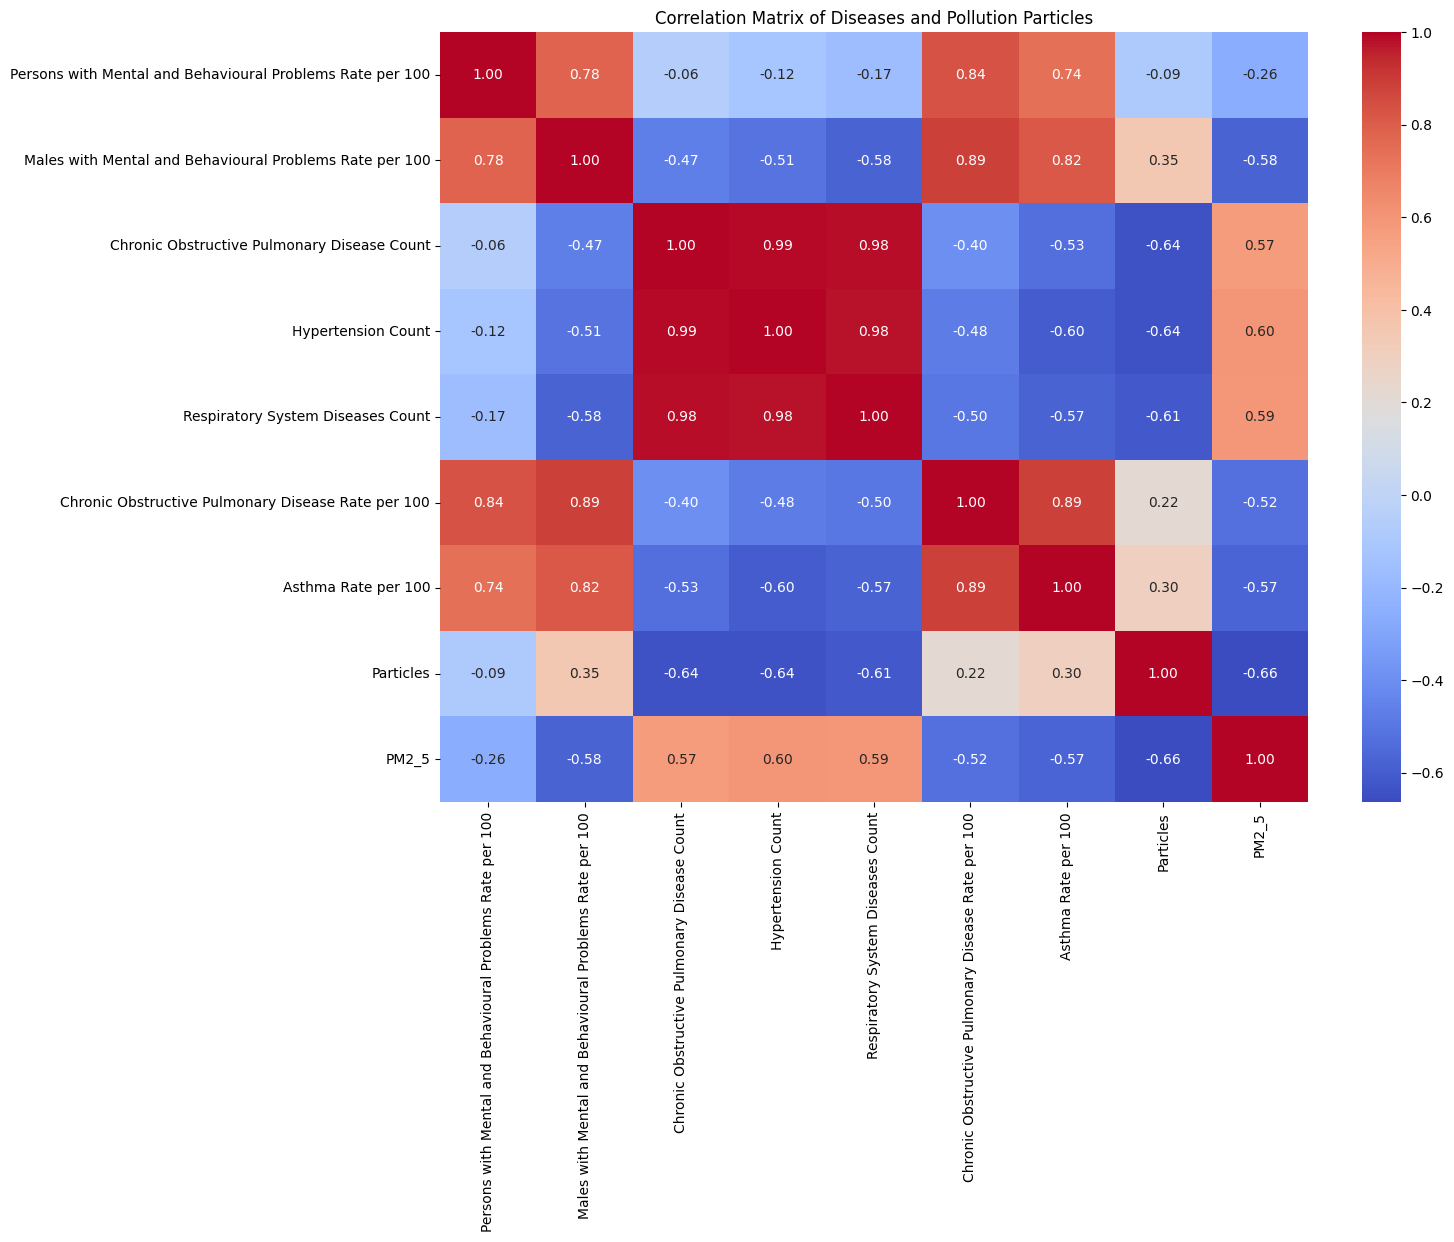

In [68]:
selected_columns = [
    'Persons with Mental and Behavioural Problems Rate per 100',
    'Males with Mental and Behavioural Problems Rate per 100',
    'Chronic Obstructive Pulmonary Disease Count',
    'Hypertension Count',
    'Respiratory System Diseases Count',
    'Chronic Obstructive Pulmonary Disease Rate per 100',
    'Asthma Rate per 100',
    'Particles',
    'PM2_5'
]

available_columns = [col for col in selected_columns if col in df.columns]
print(f'Available columns for correlation: {available_columns}')

df[available_columns] = df[available_columns].fillna(0.01)

numerical_df = df[available_columns].apply(pd.to_numeric, errors='coerce')

# 计算相关矩阵
correlation_matrix = numerical_df.corr()

# 绘制热图
plt.figure(figsize=(14, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of Diseases and Pollution Particles')
plt.show()

In [32]:
def extract_polygon_center(coordinates):
    if coordinates:
        all_coords = np.array(coordinates[0])
        center = all_coords.mean(axis=0)
        return center
    return [np.nan, np.nan]

df['Center Coordinates'] = df['Local Government Area Shape.coordinates'].apply(extract_polygon_center)

In [33]:
combined_df = pd.merge(expanded_df, df[['Local Government Area Name', 'Center Coordinates']], on='Local Government Area Name', how='left')

combined_df['Time'] = pd.to_datetime(combined_df['Time'])
combined_df.set_index('Time', inplace=True)
combined_df.head(1)

,Local Government Area Code,Local Government Area Name,Site Name,Parameter Name,TimeSeries Name,Since,Until,Average Value,Unit,Confidence,Total Sample,Health Advice,Health Advice Color,Health Code,Particles,PM2_5,PM10,Center Coordinates
Time,,,,,,,,,,,,,,,,,,
2024-05-16 11:00:00+00:00,24900,moira,Yarrawonga,Particles,1HR_AV,2024-05-16T11:00:00Z,2024-05-16T12:00:00Z,14.05,&micro;g/m&sup3;,100,12,Good,#42A93C,9999,14.05,NaN,NaN,"[145.46943744980516, -35.930065048941756]"


Training MSE: 0.8043237840783846
Test MSE: 0.4958333820129293
Training R^2: 0.11542449924784337
Test R^2: -0.4401688218552866


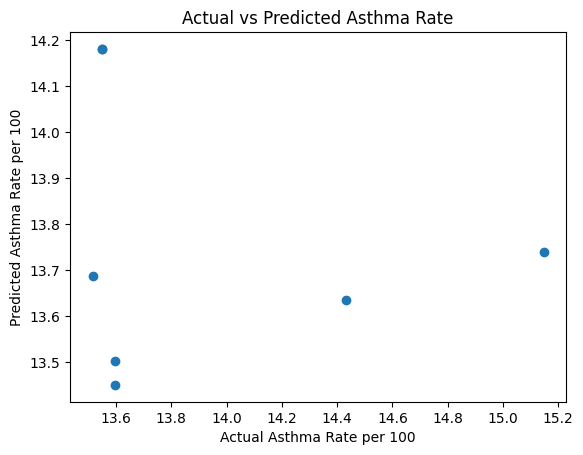

In [56]:
merged_df = pd.merge(df, combined_df, on=['Local Government Area Code', 'Local Government Area Name', 'Site Name'], suffixes=('_df', '_combined'))

features = ['Particles_combined']
target = 'Asthma Rate per 100'

merged_df = merged_df.dropna(subset=features + [target])

X = merged_df[features]
y = merged_df[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)

y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

train_mse = mean_squared_error(y_train, y_pred_train)
test_mse = mean_squared_error(y_test, y_pred_test)
train_r2 = r2_score(y_train, y_pred_train)
test_r2 = r2_score(y_test, y_pred_test)

print(f'Training MSE: {train_mse}')
print(f'Test MSE: {test_mse}')
print(f'Training R^2: {train_r2}')
print(f'Test R^2: {test_r2}')

plt.scatter(y_test, y_pred_test)
plt.xlabel('Actual Asthma Rate per 100')
plt.ylabel('Predicted Asthma Rate per 100')
plt.title('Actual vs Predicted Asthma Rate')
plt.show()

In [71]:
merged_df.head(1)

,Local Government Area Code,Local Government Area Name,Chronic Obstructive Pulmonary Disease RRMSE,Persons with Mental and Behavioural Problems Rate per 100,Asthma RRMSE,Males with Mental and Behavioural Problems Rate per 100,Chronic Obstructive Pulmonary Disease Count,Hypertension Count,Hypertension RRMSE,Respiratory System Diseases Count,...,Unit,Confidence,Total Sample,Health Advice,Health Advice Color,Health Code,Particles_combined,PM2_5_combined,PM10_combined,Center Coordinates_combined
0,24900,moira,3,14.124853,3,11.989043,746.928469,3532.220757,3,8520.394817,...,&micro;g/m&sup3;,100,12,Good,#42A93C,9999,14.05,NaN,NaN,"[145.46943744980516, -35.930065048941756]"


Training MSE: 0.660765830577093
Test MSE: 0.538231369761008
Training R^2: 0.27330600308881936
Test R^2: -0.5633155527516611


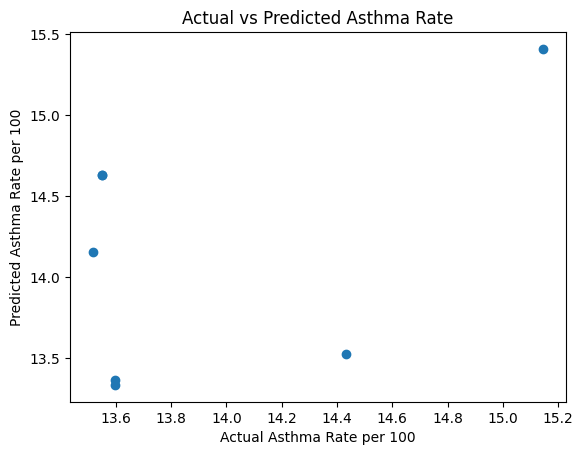

In [75]:
features = ['Particles_combined', "Chronic Obstructive Pulmonary Disease Count"]
target = 'Asthma Rate per 100'

merged_df = merged_df.dropna(subset=features + [target])

X = merged_df[features]
y = merged_df[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)

y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

train_mse = mean_squared_error(y_train, y_pred_train)
test_mse = mean_squared_error(y_test, y_pred_test)
train_r2 = r2_score(y_train, y_pred_train)
test_r2 = r2_score(y_test, y_pred_test)

print(f'Training MSE: {train_mse}')
print(f'Test MSE: {test_mse}')
print(f'Training R^2: {train_r2}')
print(f'Test R^2: {test_r2}')

plt.scatter(y_test, y_pred_test)
plt.xlabel('Actual Asthma Rate per 100')
plt.ylabel('Predicted Asthma Rate per 100')
plt.title('Actual vs Predicted Asthma Rate')
plt.show()